<a href="https://colab.research.google.com/github/im-hjk/dankook_dacon/blob/master/DACON_lrcv_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cross_val logistic reg

## 라이브러리 import 및 설정

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import io
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import seaborn as sns
import warnings

In [ ]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

## 학습데이터 로드

[03-pandas-eda.ipynb](https://github.com/kaggler-tv/dku-kaggle-class/blob/master/notebook/03-pandas-eda.ipynb)에서 생성한 `feature.csv` 피처파일 사용

In [ ]:
main_path = Path('/content/drive/My Drive/Colab Notebooks/dacon_dkdkdk')
data_dir = main_path / 'data/dacon-dku'
feature_dir = main_path / 'build/feature'
val_dir = main_path / 'build/val'
tst_dir = main_path / 'build/tst'
sub_dir = main_path / 'build/sub'

trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test.csv'
sample_file = data_dir / 'sample_submission.csv'

target_col = 'class'
n_fold = 5
n_class = 3
seed = 42

In [ ]:
algo_name = 'lrcv'
feature_name = 'polyfeature'
model_name = f'{algo_name}_{feature_name}'

feature_file = feature_dir / f'{feature_name}.csv'
p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
sub_file = sub_dir / f'{model_name}.csv'

## Polynomial Feature 생성

In [ ]:
df = pd.read_csv(feature_dir / 'feature.csv', index_col=0)
print(df.shape)
df.head()

(400000, 29)


,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nDetect,class,airmass,n_obMde,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z,u/g,u/r,u/i,u/z,g/i,g/z,r/i,r/z,i/z,d_dered_ig,d_dered_zg,d_dered_rz,d_dered_iz
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,16.9396,-8.1086e-05,23.1243,20.2578,18.9551,17.6321,16.9089,18,0.0,1.1898,0,-0.1397,-0.0790,-0.0544,-0.0403,-0.0307,1.1439,1.2238,1.3164,1.3733,1.1508,1.2005,1.0757,1.1222,1.0433,-2.6257,-3.3488,2.0462,0.7232
1,13.1689,4.5061e-03,14.9664,14.0045,13.4114,13.2363,13.1347,1,1.0,1.2533,0,-0.0857,-0.0574,-0.0410,-0.0322,-0.0343,1.0704,1.1189,1.1344,1.1430,1.0598,1.0678,1.0139,1.0215,1.0076,-0.7683,-0.8698,0.2767,0.1016
2,15.3500,4.7198e-04,16.6076,15.6866,15.4400,15.3217,15.2961,2,0.0,1.0225,0,-0.1787,-0.1388,-0.0963,-0.0718,-0.0540,1.0607,1.0805,1.0905,1.0936,1.0281,1.0310,1.0093,1.0121,1.0028,-0.3649,-0.3905,0.1440,0.0257
3,19.6346,5.8143e-06,25.3536,20.9947,20.0873,19.7947,19.5552,3,0.0,1.2054,1,-0.3070,-0.1941,-0.1339,-0.1003,-0.0795,1.2111,1.2690,1.2898,1.3069,1.0650,1.0791,1.0164,1.0299,1.0133,-1.2000,-1.4395,0.5321,0.2395
4,17.9826,-3.3247e-05,23.7714,20.4338,18.8630,18.1903,17.8759,12,0.0,1.1940,1,-0.6820,-0.2653,-0.1794,-0.1339,-0.1067,1.1814,1.2842,1.3345,1.3598,1.1296,1.1511,1.0392,1.0589,1.0190,-2.2436,-2.5579,0.9871,0.3144


In [ ]:
scaler = StandardScaler()
poly = PolynomialFeatures(2)
X = poly.fit_transform(scaler.fit_transform(df.drop(target_col, axis=1)))
feature_names = poly.get_feature_names(df.columns)
feature_names

['1',
 'z',
 'redshift',
 'dered_u',
 'dered_g',
 'dered_r',
 'dered_i',
 'dered_z',
 'nDetect',
 'class',
 'airmass',
 'n_obMde',
 'd_dered_u',
 'd_dered_g',
 'd_dered_r',
 'd_dered_i',
 'd_dered_z',
 'u/g',
 'u/r',
 'u/i',
 'u/z',
 'g/i',
 'g/z',
 'r/i',
 'r/z',
 'i/z',
 'd_dered_ig',
 'd_dered_zg',
 'd_dered_rz',
 'z^2',
 'z redshift',
 'z dered_u',
 'z dered_g',
 'z dered_r',
 'z dered_i',
 'z dered_z',
 'z nDetect',
 'z class',
 'z airmass',
 'z n_obMde',
 'z d_dered_u',
 'z d_dered_g',
 'z d_dered_r',
 'z d_dered_i',
 'z d_dered_z',
 'z u/g',
 'z u/r',
 'z u/i',
 'z u/z',
 'z g/i',
 'z g/z',
 'z r/i',
 'z r/z',
 'z i/z',
 'z d_dered_ig',
 'z d_dered_zg',
 'z d_dered_rz',
 'redshift^2',
 'redshift dered_u',
 'redshift dered_g',
 'redshift dered_r',
 'redshift dered_i',
 'redshift dered_z',
 'redshift nDetect',
 'redshift class',
 'redshift airmass',
 'redshift n_obMde',
 'redshift d_dered_u',
 'redshift d_dered_g',
 'redshift d_dered_r',
 'redshift d_dered_i',
 'redshift d_dered_z

In [ ]:
df_poly = pd.DataFrame(data=X, columns=feature_names, index=df.index)
df_poly[target_col] = df[target_col]
df_poly.head()
df_poly.to_csv(feature_file)

In [ ]:
del df_poly, df

In [ ]:
df = pd.read_csv(feature_file, index_col=0)
print(df.shape)
df.head()

(400000, 435)


,1,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nDetect,class,airmass,n_obMde,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z,u/g,u/r,u/i,u/z,g/i,g/z,r/i,r/z,i/z,d_dered_ig,d_dered_zg,d_dered_rz,z^2,z redshift,z dered_u,z dered_g,z dered_r,z dered_i,z dered_z,z nDetect,z class,z airmass,z n_obMde,z d_dered_u,z d_dered_g,z d_dered_r,z d_dered_i,z d_dered_z,z u/g,z u/r,z u/i,z u/z,z g/i,...,u/i r/z,u/i i/z,u/i d_dered_ig,u/i d_dered_zg,u/i d_dered_rz,u/z^2,u/z g/i,u/z g/z,u/z r/i,u/z r/z,u/z i/z,u/z d_dered_ig,u/z d_dered_zg,u/z d_dered_rz,g/i^2,g/i g/z,g/i r/i,g/i r/z,g/i i/z,g/i d_dered_ig,g/i d_dered_zg,g/i d_dered_rz,g/z^2,g/z r/i,g/z r/z,g/z i/z,g/z d_dered_ig,g/z d_dered_zg,g/z d_dered_rz,r/i^2,r/i r/z,r/i i/z,r/i d_dered_ig,r/i d_dered_zg,r/i d_dered_rz,r/z^2,r/z i/z,r/z d_dered_ig,r/z d_dered_zg,r/z d_dered_rz,i/z^2,i/z d_dered_ig,i/z d_dered_zg,i/z d_dered_rz,d_dered_ig^2,d_dered_ig d_dered_zg,d_dered_ig d_dered_rz,d_dered_zg^2,d_dered_zg d_dered_rz,d_dered_rz^2
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0002,-0.1093,1.8170,0.1270,0.9086,0.0208,0.0011,1.3866,0.0,-0.1895,0.1203,0.0063,0.1783,-0.0002,0.0008,1.3512,1.7027,2.0895,2.0652,1.6012,1.7938,1.5359,1.6595,0.5975,-0.0981,-0.0626,0.0367,0.0156,3.4181e-08,-2.0203e-05,0.0003,2.3488e-05,0.0002,3.8455e-06,2.0594e-07,0.0003,2.2189e-05,-3.5042e-05,2.2235e-05,1.1669e-06,3.2960e-05,-3.7490e-08,1.4942e-07,0.0002,0.0003,0.0004,0.0004,0.0003,0.0003,...,1.2339,-0.2027,-0.1293,0.0758,0.0322,2.5637e+00,2.8722,2.4593,2.6572,9.5666e-01,-1.5714e-01,-1.0024e-01,5.8746e-02,2.4937e-02,3.2177,2.7551,2.9768,1.0717,-0.1760,-1.1230e-01,0.0658,2.7937e-02,2.3591,2.5489,0.9177,-0.1507,-0.0962,0.0564,0.0239,2.7540,0.9915,-0.1629,-0.1039,0.0609,0.0258,0.3570,-0.0586,-3.7405e-02,0.0219,9.3054e-03,9.6316e-03,6.1442e-03,-3.6007e-03,-1.5285e-03,3.9195e-03,-2.2970e-03,-9.7505e-04,1.3461e-03,5.7142e-04,2.4256e-04
1,1.0,-0.0719,-0.1007,-2.4251,-0.2656,-2.8534,-0.1751,-0.1054,-0.6014,1.0,-0.1895,0.1974,0.0081,0.2144,0.0001,0.0007,-0.1347,-0.0098,-0.1683,-0.2211,-0.1014,-0.2017,-0.3338,-0.3753,-0.1464,0.0190,0.0156,-0.0133,-0.0071,5.1738e-03,7.2464e-03,0.1744,1.9104e-02,0.2052,1.2597e-02,7.5809e-03,0.0433,-4.7881e-02,1.3633e-02,-1.4200e-02,-5.8349e-04,-1.5419e-02,-8.7153e-06,-5.1123e-05,0.0097,0.0007,0.0121,0.0159,0.0073,0.0145,...,0.0324,-0.0042,-0.0035,0.0029,0.0016,1.0279e-02,0.0204,0.0338,0.0380,1.4845e-02,-1.9222e-03,-1.5841e-03,1.3456e-03,7.1856e-04,0.0407,0.0673,0.0757,0.0295,-0.0038,-3.1514e-03,0.0027,1.4295e-03,0.1114,0.1253,0.0489,-0.0063,-0.0052,0.0044,0.0024,0.1408,0.0549,-0.0071,-0.0059,0.0050,0.0027,0.0214,-0.0028,-2.2877e-03,0.0019,1.0377e-03,3.5943e-04,2.9622e-04,-2.5161e-04,-1.3437e-04,2.4412e-04,-2.0736e-04,-1.1074e-04,1.7613e-04,9.4060e-05,5.0230e-05
2,1.0,-0.0302,-0.1082,-1.5717,-0.1600,-1.4768,-0.0822,-0.0444,-0.4844,0.0,-0.1895,0.0645,0.0013,0.0650,-0.0015,0.0002,-0.3306,-0.6376,-0.7136,-0.7117,-0.6957,-0.7556,-0.4726,-0.5651,-0.2448,0.0444,0.0308,-0.0170,-0.0099,9.1298e-04,3.2708e-03,0.0475,4.8338e-03,0.0446,2.4830e-03,1.3416e-03,0.0146,3.9820e-02,5.7269e-03,-1.9476e-03,-3.9487e-05,-1.9652e-03,4.4024e-05,-5.3424e-06,0.0100,0.0193,0.0216,0.0215,0.0210,0.0228,...,0.1742,-0.0316,-0.0219,0.0121,0.0070,4.8394e-01,0.5256,0.3288,0.3931,1.7030e-01,-3.0881e-02,-2.1392e-02,1.1840e-02,6.8558e-03,0.5709,0.3571,0.4270,0.1850,-0.0335,-2.3235e-02,0.0129,7.4464e-03,0.2234,0.2671,0.1157,-0.0210,-0.0145,0.0080,0.0047,0.3193,0.1383,-0.0251,-0.0174,0.0096,0.0056,0.0599,-0.0109,-7.5279e-03,0.0042,2.4126e-03,1.9706e-03,1.3651e-03,-7.5553e-04,-4.3748e-04,9.4561e-04,-5.2337e-04,-3.0305e-04,2.8967e-04,1.6773e-04,9.7124e-05
3,1.0,0.0517,-0.1091,2.9763,0.1733,1.6769,0.1172,0.0758,-0.3675,0.0,0.7897,-0.1189,-0.0033,-0.0366,-0.0026,-0.0005,2.7077,2.4405,1.7596,1.4057,-0.0036,-0.0313,-0.2572,-0.2066,-0.0276,-0.0083,-0.0024,-0.0061,-0.0021,2.6757e-03,-5.6442e-03,0.1540,8.9650e-03,0.0867,6.0617e-03,3.9204e-03,-0.0190,1.3160e-02,4.0851e-0

In [ ]:
y = df[target_col].values[:320000]
df.drop(target_col, axis=1, inplace=True)
trn = df.iloc[:320000].values
tst = df.iloc[320000:].values
feature_name = df.columns.tolist()
print(y.shape, trn.shape, tst.shape)

(320000,) (320000, 434) (80000, 434)


## Stratified K-Fold Cross Validation

In [ ]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

## Logistic Regression 모델 학습

In [ ]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    clf = LogisticRegression(multi_class='multinomial')
    clf.fit(trn[i_trn], y[i_trn])
    p_val[i_val, :] = clf.predict_proba(trn[i_val])
    p_tst += clf.predict_proba(tst) / n_fold

training model for CV #1
training model for CV #2
training model for CV #3
training model for CV #4
training model for CV #5


In [ ]:
print(f'{accuracy_score(y, np.argmax(p_val, axis=1)) * 100:.4f}%')

87.1056%


In [ ]:
print(p_val.shape, p_tst.shape)

(320000, 3) (80000, 3)


In [ ]:
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

## 피처 중요도 시각화

In [ ]:
clf.coef_.shape

(3, 434)

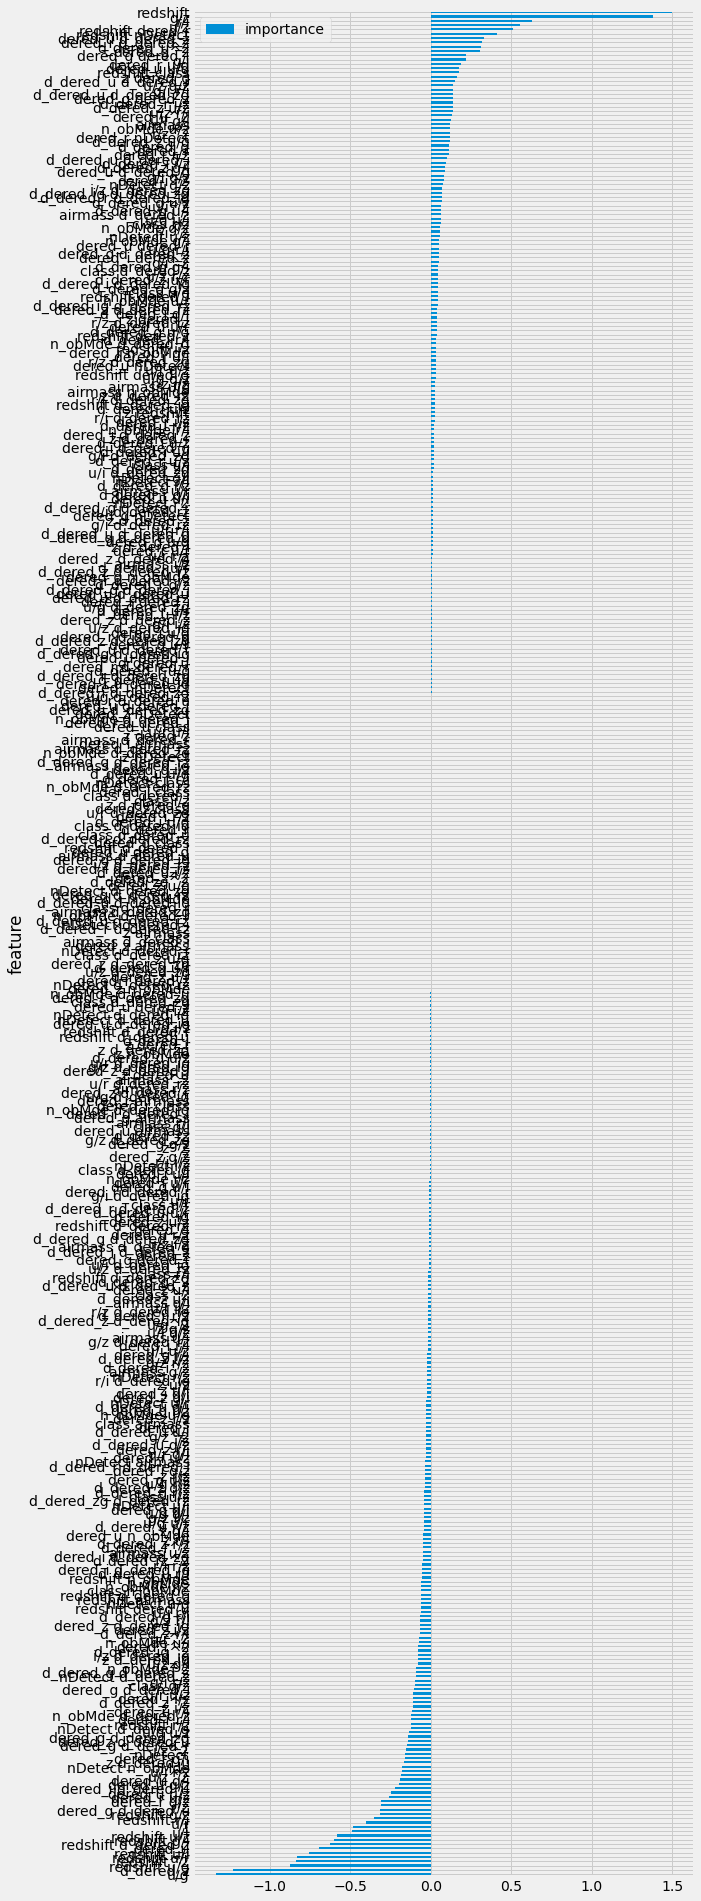

In [ ]:
imp = pd.DataFrame({'feature': df.columns, 'importance': clf.coef_[1, :].T})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh', figsize=(8, 32))

## 제출 파일 생성

In [ ]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(80000, 1)


,class
id,
320000,0
320001,0
320002,0
320003,0
320004,0


In [ ]:
sub[target_col] = np.argmax(p_tst, axis=1)
sub.head()

,class
id,
320000,2
320001,0
320002,2
320003,0
320004,2


In [ ]:
sub[target_col].value_counts()

2    43391
0    30008
1     6601
Name: class, dtype: int64

In [ ]:
sub.to_csv(sub_file)